In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



## Carga y preparación de datos 

In [9]:
# Cargar el dataset
data = pd.read_csv("Temp_Asu20092021.csv")

# Convertir la columna 'Fecha' a tipo datetime y establecerla como índice
data['Fecha'] = pd.to_datetime(data['Fecha'])
data.set_index('Fecha', inplace=True)

# Filtrar datos desde 2019 en adelante
data = data[data.index.year >= 2019]

# Interpolar valores faltantes
data.interpolate(method='time', inplace=True)

## Resampleo y cálculo de características

In [10]:
#  Resamplear para obtener temperatura máxima, mínima y media diarias
daily_max_temperatures = data['Temperatura'].resample('D').max()
daily_min_temperatures = data['Temperatura'].resample('D').min()
daily_mean_temperatures = data['Temperatura'].resample('D').mean()

# Calcular percentil 95 diario
daily_percentile_95 = data['Temperatura'].resample('D').quantile(0.95)

# Calcular temperatura promedio mensual
monthly_avg_temp = daily_max_temperatures.resample('M').mean()

# Crear un DataFrame con las características
daily_data = pd.DataFrame({
    'temp_max': daily_max_temperatures,
    'temp_min': daily_min_temperatures,
    'temp_mean': daily_mean_temperatures,
    'percentile_95': daily_percentile_95,
    'monthly_avg_temp': daily_max_temperatures.index.to_series().map(lambda x: monthly_avg_temp.loc[x.strftime('%Y-%m')])
})

# Añadir características estacionales (mes y día del año)
daily_data['month'] = daily_data.index.month
daily_data['day_of_year'] = daily_data.index.day_of_year

C:\Users\vegah\AppData\Local\Temp\ipykernel_10356\2753560604.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_temp = daily_max_temperatures.resample('M').mean()


In [11]:
# Crear la variable objetivo (temperatura máxima del día siguiente)
salida = daily_data['temp_max'].shift(-1)

# Eliminar el último valor faltante
daily_data = daily_data[:-1]
salida = salida[:-1]

#  Definir características (X) y variable objetivo (y)
X = daily_data.values
y = salida.values

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

c:\Users\vegah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py:745: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
c:\Users\vegah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py:745: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


## Entrenamiento y optimización de hiperparametros


In [12]:
#  Definir el modelo de regresión Ridge
ridge = Ridge()

# Definir la cuadrícula de parámetros para GridSearch
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

# Usar GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(ridge, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

## Evaluación del modelo

In [13]:
# 5. Evaluar el modelo en el conjunto de validación
y_pred = best_model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"RMSE: {rmse}, MAE: {mae}, R²: {r2}")

Mejores hiperparámetros: {'alpha': 0.1}
RMSE: 4.338110790547362, MAE: 3.3911221499906183, R²: 0.645397977734382


## Gráficos

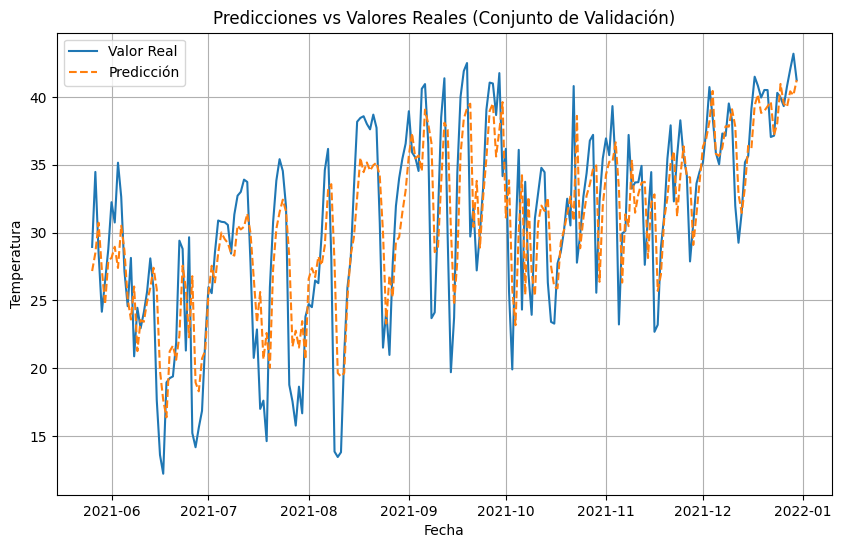

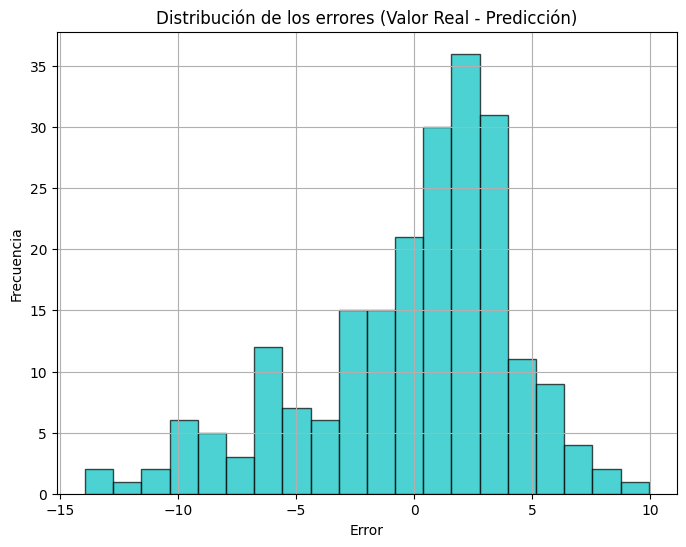

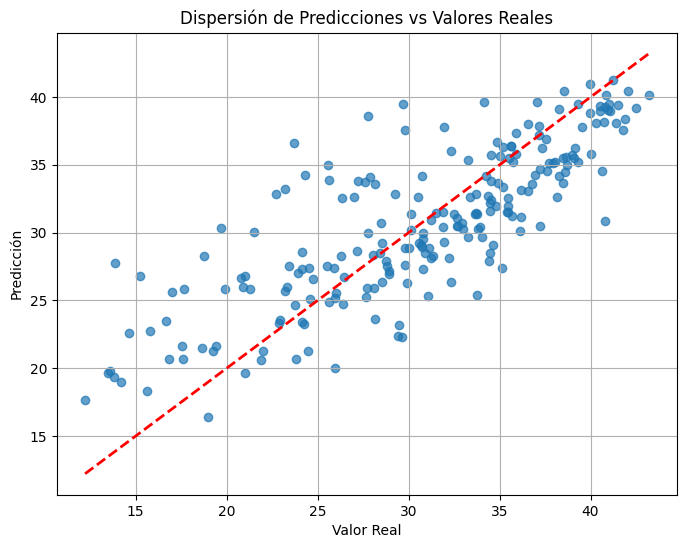

In [14]:
# Graficar los resultados

# Predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index[-len(y_val):], y_val, label='Valor Real')
plt.plot(daily_data.index[-len(y_val):], y_pred, label='Predicción', linestyle='--')
plt.title('Predicciones vs Valores Reales (Conjunto de Validación)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.show()

# Distribución de errores
plt.figure(figsize=(8, 6))
plt.hist(y_val - y_pred, bins=20, color='c', edgecolor='k', alpha=0.7)
plt.title('Distribución de los errores (Valor Real - Predicción)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Gráfico de dispersión: valores reales vs predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.title('Dispersión de Predicciones vs Valores Reales')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.grid(True)
plt.show()